### This notebook describes the TE variation analysis of myrtle rust

This notebook and analysis is based on a discussion with Cecile Lorrain and on the following paper https://www.nature.com/articles/ncomms5104.  

#### TE analysis in regards to conservation and age

In [66]:
%matplotlib inline
import pandas as pd
import os
import re
from Bio import SeqIO
import pysam
from Bio.SeqRecord import SeqRecord
from Bio import SeqUtils
from Bio.Seq import Seq
from Bio import SearchIO
from pybedtools import BedTool
import numpy as np
import pybedtools
import multiprocessing
import re
import time
import matplotlib.pyplot as plt
import json
from ipywidgets import widgets
from IPython.display import display
from sklearn.externals.joblib import Parallel, delayed
import seaborn as sns
import matplotlib
import subprocess
import scipy.stats
import statsmodels.stats.multitest

In [2]:
def get_TE_diversity_df(genome_repet, TE_postanalysis_dir):
    """Get the combined repet TE dataframe with proper annotation."""
    TE_post_analysis_p_header = 'TE      length  covg    frags   fullLgthFrags   copies  fullLgthCopies  meanId  sdId    minId   q25Id   medId   q75Id   maxId   meanLgth        sdLgth  minLgth q25Lgth medLgth q75Lgth maxLgth meanLgthPerc    sdLgthPerc      \
    minLgthPerc  q25LgthPerc     medLgthPerc     q75LgthPerc     maxLgthPerc'.split(' ')
    TE_post_analysis_p_header = [x for x in TE_post_analysis_p_header if x != '']
    #now get the summary of allTEs == TEs specificaly identified by TEdenovo from REPET
    REPET_denovoTEs_df = pd.read_csv(\
            os.path.join(TE_postanalysis_dir, '%s_chr_allTEs_nr_noSSR_join_path.annotStatsPerTE.tab' % genome_repet),\
                                    names = TE_post_analysis_p_header, header=None, sep='\t', skiprows=1 )

    #now get in the summary of all bankBLRx TEs == TEs identified by repbase20.05_ntSeq_cleaned_TE
    REPET_nt_repbase_df = pd.read_csv(\
        os.path.join(TE_postanalysis_dir, '%s_chr_bankBLRx_path.annotStatsPerTE.tab' % genome_repet) ,\
        names = TE_post_analysis_p_header, header=None, sep='\t', skiprows=1 )

    #now get in the summary of all bankBLRtx TEs == TEs identified by repbase20.05_aaSeq_cleaned_TE
    REPET_aa_repbase_df = pd.read_csv(\
        os.path.join(TE_postanalysis_dir, '%s_chr_bankBLRtx_path.annotStatsPerTE.tab' % genome_repet) ,\
        names = TE_post_analysis_p_header, header=None, sep='\t', skiprows=1 )
    #generate a df that contains all TEs: TEdenovo, blastx, blastn
    REPET_all_TEs_df = pd.concat([REPET_denovoTEs_df ,REPET_nt_repbase_df,\
                                       REPET_aa_repbase_df], axis=0)
    REPET_all_TEs_df = REPET_all_TEs_df[REPET_all_TEs_df.copies > 0]
    REPET_all_TEs_df = REPET_all_TEs_df[~REPET_all_TEs_df.TE.str.startswith("Potential")]
    intervals = pd.interval_range(start=20, end=100, closed='right', periods=100)
    REPET_all_TEs_df['Intervals'] = pd.cut(REPET_all_TEs_df.meanId, intervals)

    grouped = REPET_all_TEs_df.groupby('Intervals')
    sum_df = grouped.agg({'meanId': 'mean', 'covg': 'sum'})
    sum_df['Interval_edge'] = intervals.right
    sum_df['freq_covg'] = sum_df.covg / sum_df.covg.sum()
    sum_df["re_cumsum_covg"] = sum_df.sort_values('Interval_edge', ascending='False')['covg'].cumsum()
    return REPET_all_TEs_df, sum_df

In [3]:
def AT_content_df(bed_fn, contig_fn, intervals, merge=True):
    """A function that takes bedfile filename, a contig_fn (fasta), and certain intverals.
    This is counts the AT content per bed window and does some bining for certain AT% intervals.
    Input: 
    bed_fn   File name of bedfile to investigate.
    contig_fn File name of fasta sequences of the corresponding contigs.
    intervals Interval file used to bin the %AT regions.
    
    Returns:
    df       Dataframe with %AT for each window.
    sum_df   Binned dataframe for %AT bins and their frequency."""
    bed = BedTool(bed_fn)
    if merge == True:
        bed.sort().merge()
    #specify datatypes if possible
    tmp_fn = bed_fn.replace('.bed', '.AT.bed.tmp')
    dtype_dict = {0:str, 1:np.int32, 2:np.int32, 3:str, 4:str, 5:str, 6:float}
    bed.nucleotide_content(fi=contig_fn).saveas(tmp_fn)
    #bedtools nuc -fi {contig_fn} -bed {bed_fn} > {tmp_fn}
    
    if len(bed.to_dataframe().columns) == 6:
        dtype_dict = {0:str, 1:np.int32, 2:np.int32, 3:str, 4:str, 5:str, 6:float}
        df = pd.read_csv( tmp_fn, sep='\t',header=None,dtype=dtype_dict, usecols=[0,1,2,3,6], skiprows=1)
        df.rename(columns={6:'%AT'}, inplace=True)
    elif len(bed.to_dataframe().columns) == 3:
        dtype_dict = {0:str, 1:np.int32, 2:np.int32, 3:float}
        df = pd.read_csv( tmp_fn, sep='\t',header=None,dtype=dtype_dict, usecols=[0,1,2,3], skiprows=1)
        df.rename(columns={3:'%AT'}, inplace=True)
    df['%AT'] = df['%AT'].astype('float')
    df['W_Len'] = df[2] - df[1]
    
    df['Intervals'] = pd.cut(df['%AT'], intervals)
    grouped = df.groupby('Intervals')
    ###group by the edge
    ####get the length of the intervals and plot the sum for each interval
    ###edge
    
    
    sum_df = grouped.agg({'%AT': 'count', 'W_Len': 'sum'})
    sum_df['Interval_edge'] = intervals.right
    sum_df.fillna(0, inplace=True)
    sum_df['norm_count_AT'] = sum_df['%AT']/sum_df['%AT'].sum()
    sum_df['norm_W_Len'] = sum_df['W_Len']/sum_df['W_Len'].sum()
    os.remove(tmp_fn)
    return df, sum_df

In [4]:
#define all the path variables, keys, and such
genomes = ["APSI_primary_v1"]
repet_genomes = [ 'MR_P2_a0']
genome_folder = '../../genome'
repet_post_dir = {}
repet_post_dir['APSI_primary_v1'] = '../../../genome_v03/REPET/TEannot/primary'

sum_df_dict = {}
REPET_all_TEs_df_dict ={}


In [5]:
##OUTPATH for figures
OUTPATH='../../TE_analysis/'
##OUTPATH for figures
OUTPATH_Figures='../../figures/'

In [6]:
for genome, r_genome in zip(genomes, repet_genomes):
    print(genome, r_genome)
    REPET_all_TEs_df_dict[genome] ,sum_df_dict[genome] = get_TE_diversity_df(r_genome, repet_post_dir[genome])

APSI_primary_v1 MR_P2_a0


In [7]:
from scipy.interpolate import interp1d
import matplotlib
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 14}

matplotlib.rc('font', **font)

In [8]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 20}
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
matplotlib.rc('font', **font)

In [9]:
os.path.abspath(OUTPATH_Figures)

'/home/benjamin/myrtle_rust/genome_v03/figures'

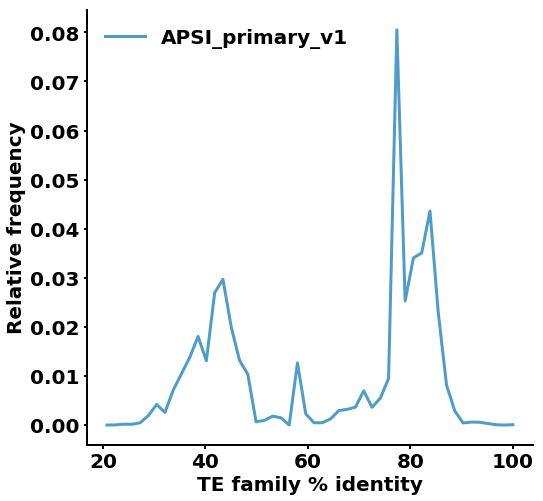

In [10]:
f, ax = plt.subplots(figsize=(8,8))
pallete = [sns.color_palette('colorblind')[x] for x in [0,1]]
for genome, color in zip(genomes, pallete):
    x, y = sum_df_dict[genome]['Interval_edge'], sum_df_dict[genome]['freq_covg']
    f2 = interp1d(x, y)
    xnew = np.linspace(x.min(), x.max(), num=50, endpoint=True)
    ax.plot(xnew, f2(xnew), '-', color=color, label = genome,  linewidth=3, alpha = 0.7)
ax.legend()
ax.set_ylabel('Relative frequency', **font)
ax.set_xlabel('TE family % identity', **font)
plt.legend(loc='upper left', frameon=False)
#['top','bottom','left','right']
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
ax.tick_params(width=2)

outfn = os.path.join(OUTPATH_Figures, 'APSI_primary_v1.TE_family_variation_analysis.png')

plt.savefig(outfn, dpi=600,bbox_inches='tight')

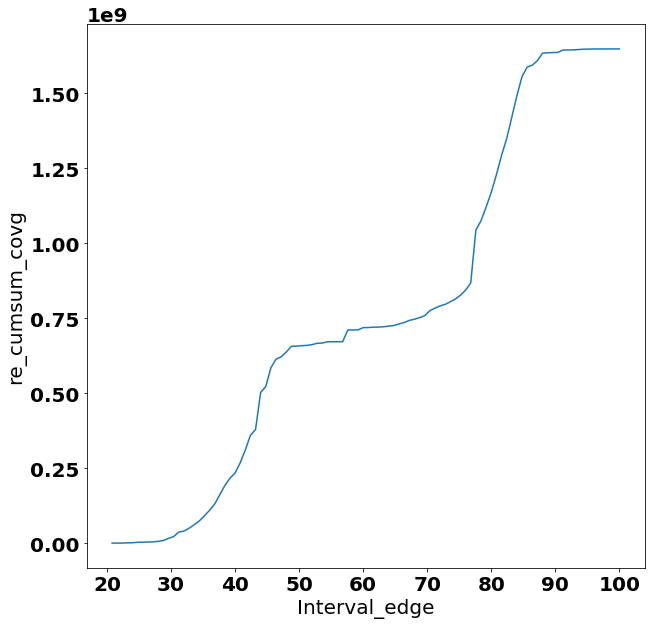

In [11]:
f, ax = plt.subplots(figsize=(10,10))
for genome in genomes:
    sns.lineplot(sum_df_dict[genome]['Interval_edge'], sum_df_dict[genome]["re_cumsum_covg"], ax=ax)

### Look at the Relationship between GC content of consensus sequences and consensus identidy

In [15]:
def add_GC(x):
    if x in TE_GC_dict.keys():
        return TE_GC_dict[x]
    else:
        return 0

In [16]:
def add_COS(x):
    if x in COS_dict.keys():
        return COS_dict[x]
    else:
        return False

In [17]:
REPET_sum_df = pd.read_csv('../../TE_analysis/APSI_primary_v1.MR_P2A_300Mb.REPET.long_v2.df', header = None, sep = '\t')
TE_databases = []
TE_databases.append('../../REPET/TEannot/primary/MR_P2_a0_refTEs.fa') #specific TEs
TE_databases.append('../../../REPET/genome_v01/repbase20.05_ntSeq_cleaned_TE.fa') #general TEs

In [18]:
TE_df = REPET_all_TEs_df_dict[genome]

In [19]:
COS_dict = dict(zip(REPET_sum_df.iloc[:, -6], REPET_sum_df.iloc[:, -5]))
#COS_dict['DTX-incomp_Blc4560_MR_P2A_100Mb_RS_258'] = 'ClassII:TIR:hAT' some are missing from the summary REPET file in the ID column. Likely double hits.
TE_df['COS'] = TE_df['TE'].apply(lambda x: add_COS(x))

In [20]:
###Get the GC content
TE_GC_dict = {}
for file in TE_databases:
    for seq in SeqIO.parse(file, 'fasta'):
        TE_GC_dict[seq.id] = SeqUtils.GC(seq.seq)

In [21]:
GC_intervals = pd.interval_range(start=50, end=100, closed='right', periods=10)
TE_df[ 'GC_intervals' ] = pd.cut(TE_df['meanId'], GC_intervals)

In [23]:
TE_df['%GC'] = np.nan
TE_df['%GC'] = TE_df['TE'].apply(lambda x: add_GC(x))
#drop TEs with none nt sequence in the consensus databases
TE_df = TE_df[~(TE_df['%GC'] == 0.0)]
#TE_df.drop(index = TE_df[TE_df['%GC'] == 0.0].index, inplace = True)
TE_df.reset_index(drop = True, inplace = True)

In [25]:
TE_df['GC_intervals_sumcovg'] = np.nan
for i, tmp_sum in zip(TE_df.groupby('GC_intervals')['covg'].sum().index, TE_df.groupby('GC_intervals')['covg'].sum()):
    tmp_index = TE_df[TE_df['GC_intervals'] ==  i].index
    TE_df.loc[tmp_index, 'GC_intervals_sumcovg'] = tmp_sum
TE_df['GC_intervals_rel_cov'] = TE_df['covg']/TE_df['GC_intervals_sumcovg']
TE_df['GC_intervals_rel_GC'] = TE_df['%GC']*TE_df['GC_intervals_rel_cov']

/home/benjamin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/benjamin/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/benjamin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [27]:
TE_df.sort_values('covg', ascending=False).head()

,TE,length,covg,frags,fullLgthFrags,copies,fullLgthCopies,meanId,sdId,minId,...,medLgthPerc,q75LgthPerc,maxLgthPerc,Intervals,COS,GC_intervals,%GC,GC_intervals_sumcovg,GC_intervals_rel_cov,GC_intervals_rel_GC
1679,RLX-incomp-chim_Blc22_MR_P2A_300Mb-L-B1-Map20_...,120268,144512997,77731,0,41819,0,77.23,9.89,55.20,...,1.57,4.18,25.90,"(76.80000000000001, 77.6]",ClassI:LTR:Gypsy,"(75, 80]",29.435095,349484629.0,0.413503,12.171505
8545,Gypsy-17_PGr-I:ClassI:LTR:Gypsy,7653,39660914,110627,0,98710,0,43.75,9.04,17.72,...,2.93,6.12,49.77,"(43.2, 44.0]",ClassI:LTR:Gypsy,NaN,42.911277,NaN,NaN,NaN
10927,Gypsy-7_PSt-I:ClassI:LTR:Gypsy,4626,17689338,43412,0,37068,0,48.13,7.66,19.30,...,6.81,13.83,63.79,"(48.0, 48.8]",ClassI:LTR:Gypsy,NaN,42.001729,NaN,NaN,NaN
9042,Gypsy-22_PGr-I:ClassI:LTR:Gypsy,6921,14035426,37540,0,34373,0,41.88,6.74,16.95,...,4.93,7.50,48.59,"(41.6, 42.400000000000006]",ClassI:LTR:Gypsy,NaN,41.309059,NaN,NaN,NaN
7780,Gypsy-101_MLP-I:ClassI:LTR:Gypsy,7917,12859049,34737,0,30924,0,41.51,6.25,17.95,...,1.33,4.17,45.37,"(40.8, 41.6]",ClassI:LTR:Gypsy,NaN,40.634079,NaN,NaN,NaN


In [28]:
TE_df.groupby('GC_intervals')['covg'].sum().index

CategoricalIndex([ (50, 55],  (55, 60],  (60, 65],  (65, 70],  (70, 75],
                   (75, 80],  (80, 85],  (85, 90],  (90, 95], (95, 100]],
                 categories=[(50, 55], (55, 60], (60, 65], (65, 70], (70, 75], (75, 80], (80, 85], (85, 90], ...], ordered=True, name='GC_intervals', dtype='category')

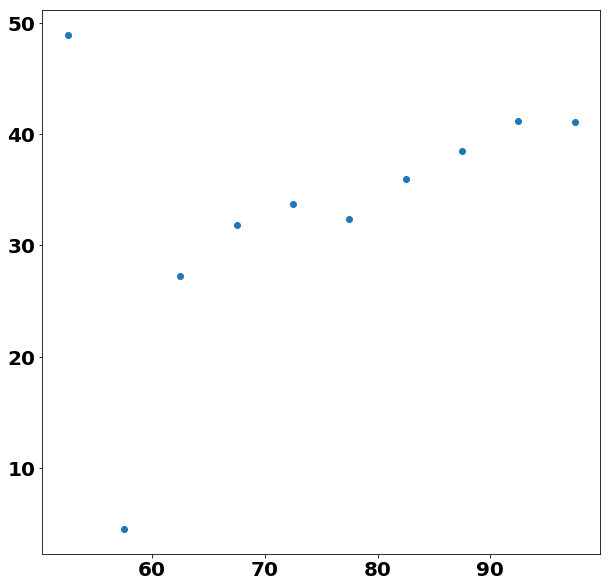

In [29]:
fig, ax = plt.subplots(figsize = (10,10))
y = TE_df.groupby('GC_intervals')['GC_intervals_rel_GC'].sum()
x = [x.mid for x in TE_df.groupby('GC_intervals')['%GC'].mean().index.tolist()]
ax.scatter(x,y)

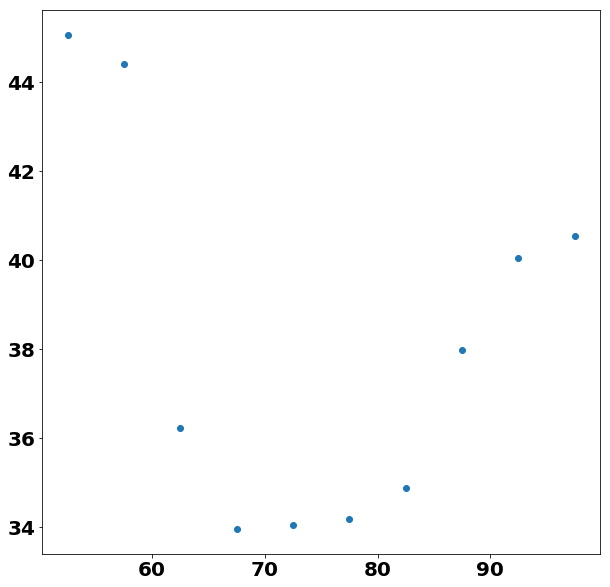

In [30]:
fig, ax = plt.subplots(figsize = (10,10))
y = TE_df.groupby('GC_intervals')['%GC'].median()
x = [x.mid for x in TE_df.groupby('GC_intervals')['%GC'].mean().index.tolist()]
ax.scatter(x,y)

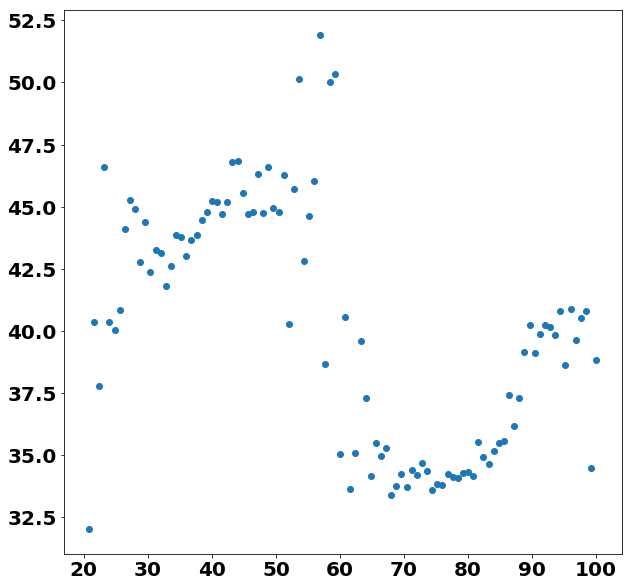

In [31]:
###The rising up is a artificat from TE consensus of REPET vs. reference db TEs.
fig, ax = plt.subplots(figsize = (10,10))
y = TE_df.groupby('Intervals')['%GC'].median()
x = [x.right for x in TE_df.groupby('Intervals')['%GC'].mean().index.tolist()]
ax.scatter(x,y)


# Analysis only witht the REPET TEs for consistency

The idea here is that older TEs based on mean Identity increase in AT-% due mutations C-T via 5mC demamination.

In [32]:
####look at REPET TEs only
TE_post_analysis_p_header = ['TE', 'length' ,'covg', 'frags', 'fullLgthFrags', 'copies', 'fullLgthCopies' , 'meanId', 'sdId', 'minId',   
                             'q25Id', 'medId', 'q75Id', 'maxId', 'meanLgth', 'sdLgth', 'minLgth', 'q25Lgth', 'medLgth', 'q75Lgth', 'maxLgth',
                             'meanLgthPerc', 'sdLgthPerc' , 'minLgthPerc', 'q25LgthPerc', 'medLgthPerc', 'q75LgthPerc', 'maxLgthPerc']
REPET_denovoTEs_df = pd.read_csv(\
            os.path.join(repet_post_dir['APSI_primary_v1'], '%s_chr_allTEs_nr_noSSR_join_path.annotStatsPerTE.tab' % 'MR_P2_a0'),\
                                    names = TE_post_analysis_p_header, header=None, sep='\t', skiprows=1 )

In [33]:
GC_intervals = pd.interval_range(start=70, end=100, closed='right', periods=6)
REPET_denovoTEs_df[ 'GC_intervals' ] = pd.cut(REPET_denovoTEs_df['meanId'], GC_intervals)
REPET_denovoTEs_df['%GC'] = 0
REPET_denovoTEs_df['%GC'] = REPET_denovoTEs_df['TE'].apply(lambda x: add_GC(x))
REPET_denovoTEs_df['COS'] = REPET_denovoTEs_df['TE'].apply(lambda x: add_COS(x))
#REPET_denovoTEs_df = REPET_denovoTEs_df[(REPET_denovoTEs_df['%GC'] > 10)]

In [34]:
intervals = pd.interval_range(start=70, end=100, closed='right', periods=30)
REPET_denovoTEs_df['Intervals'] = pd.cut(REPET_denovoTEs_df.meanId, intervals)

In [35]:
REPET_denovoTEs_df[ 'Intervals'].unique()

[NaN, (77, 78], (80, 81], (84, 85], (78, 79], ..., (94, 95], (97, 98], (99, 100], (95, 96], (98, 99]]
Length: 31
Categories (30, interval[int64]): [(70, 71] < (71, 72] < (72, 73] < (73, 74] ... (96, 97] < (97, 98] < (98, 99] < (99, 100]]

In [36]:
REPET_denovoTEs_df['GC_intervals_sumcovg'] = np.nan
for i, tmp_sum in zip(REPET_denovoTEs_df.groupby('GC_intervals')['covg'].sum().index, REPET_denovoTEs_df.groupby('GC_intervals')['covg'].sum()):
    tmp_index = REPET_denovoTEs_df[REPET_denovoTEs_df['GC_intervals'] ==  i].index
    #print(REPET_denovoTEs_df[REPET_denovoTEs_df['GC_intervals'] ==  i]['GC_intervals_rel_cov'].sum())
    REPET_denovoTEs_df.loc[tmp_index, 'GC_intervals_sumcovg'] = tmp_sum
REPET_denovoTEs_df['GC_intervals_rel_cov'] = REPET_denovoTEs_df['covg']/REPET_denovoTEs_df['GC_intervals_sumcovg']
REPET_denovoTEs_df['GC_intervals_rel_GC'] = REPET_denovoTEs_df['%GC']*REPET_denovoTEs_df['GC_intervals_rel_cov']

In [37]:
#REPET_denovoTEs_df.sort_values('GC_intervals_rel_GC', ascending=False).head(5)

In [38]:
GC_intervals[1]

Interval(75, 80, closed='right')

In [39]:
REPET_denovoTEs_df['COS'].unique()

array(['ClassII:Helitron:?', 'ClassII:Maverick:?', 'ClassII:TIR:hAT',
       'ClassII:TIR:PIF-Harbinger', 'ClassII:TIR:Tc1-Mariner',
       'ClassII:TIR:CACTA', 'ClassII:TIR:?', 'ClassII:TIR:MuDR', False,
       'ClassII:MITE:?', 'ClassII:?:?', 'noCat', 'ClassI:LINE:I',
       'ClassI:LINE:?', 'ClassI:LTR:Gypsy', 'ClassI:LTR:?',
       'ClassI:LTR:Copia', 'ClassI:LTR:Bel-Pao', 'ClassI:SINE:?',
       'ClassI:LARD:?', 'ClassII:?:Novosib', 'ClassI:TRIM:?',
       'ClassII:Crypton:Crypton', 'ClassII:Helitron:Helitron',
       'ClassII:?:Ginger2_TDD', 'ClassI:?:?', 'ClassI:DIRS:?'], dtype=object)

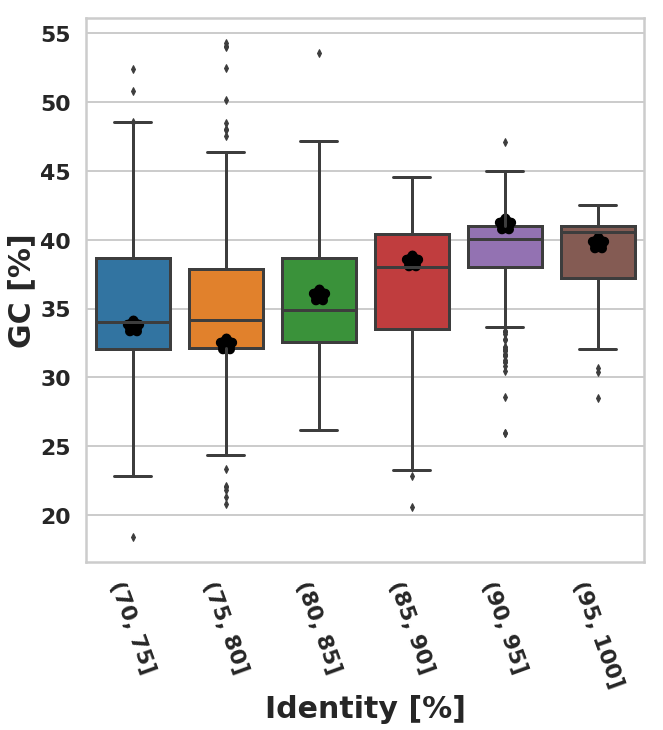

In [47]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 30}

sns.set_style("whitegrid")
sns.set_context("poster")
fig, ax = plt.subplots(figsize = (10,10))
sns.boxplot(x= 'GC_intervals', y='%GC', data = REPET_denovoTEs_df, ax = ax)
x = ax.get_xticks()
ax.set_xticklabels(ax.get_xticklabels(), rotation = -70)
y = REPET_denovoTEs_df.groupby('GC_intervals')['GC_intervals_rel_GC'].sum()
ax.scatter(x,y, linewidths=10, color = 'black', marker = '*')
ax.set_xlabel('Identity [%]', **font)
ax.set_ylabel('GC [%]', **font)
out_fn = os.path.join(OUTPATH_Figures, 'TE_perID_vs_GC_consensus.png')
fig.savefig(out_fn, dpi=600, bbox_inches = "tight")

In [55]:
#maybe do some stats here with Kurtkurfalis https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html and one-to-one testing with corrections.
comparative_ints = REPET_denovoTEs_df.GC_intervals.unique()[1:]
comparative_array = []
for x in comparative_ints:
    comparative_array.append(REPET_denovoTEs_df[REPET_denovoTEs_df['GC_intervals']== x]['%GC'].values)

In [61]:
#do the overall 'ANOVA'
scipy.stats.kruskal(comparative_array[0],comparative_array[1], comparative_array[2], comparative_array[3], comparative_array[4], comparative_array[5])

KruskalResult(statistic=275.26453612024608, pvalue=2.0712579882410828e-57)

In [63]:
#do the individual tests
comparative_dict = {}
for x in comparative_ints:
    for y in comparative_ints:
        key = '%s_vs_%s' % (x, y)
        comparative_dict[key] = scipy.stats.mannwhitneyu(REPET_denovoTEs_df[REPET_denovoTEs_df['GC_intervals']== x]['%GC'].values, \
                                                         REPET_denovoTEs_df[REPET_denovoTEs_df['GC_intervals']== y]['%GC'].values)

In [73]:
comparative_dict

{'(70, 75]_vs_(70, 75]': MannwhitneyuResult(statistic=346112.0, pvalue=0.49997964643525356),
 '(70, 75]_vs_(75, 80]': MannwhitneyuResult(statistic=635204.5, pvalue=0.14517304026006034),
 '(70, 75]_vs_(80, 85]': MannwhitneyuResult(statistic=481283.0, pvalue=0.020113709764817855),
 '(70, 75]_vs_(85, 90]': MannwhitneyuResult(statistic=146386.5, pvalue=3.8617374743363106e-13),
 '(70, 75]_vs_(90, 95]': MannwhitneyuResult(statistic=41338.0, pvalue=1.7484811220595493e-29),
 '(70, 75]_vs_(95, 100]': MannwhitneyuResult(statistic=10043.0, pvalue=9.8274177847059186e-09),
 '(75, 80]_vs_(70, 75]': MannwhitneyuResult(statistic=635204.5, pvalue=0.14517304026006034),
 '(75, 80]_vs_(75, 80]': MannwhitneyuResult(statistic=1229312.0, pvalue=0.49999213194398034),
 '(75, 80]_vs_(80, 85]': MannwhitneyuResult(statistic=871578.5, pvalue=2.1015304462441174e-05),
 '(75, 80]_vs_(85, 90]': MannwhitneyuResult(statistic=258438.5, pvalue=2.0546710240308854e-21),
 '(75, 80]_vs_(90, 95]': MannwhitneyuResult(statistic=

In [74]:
#do the multipletesting correction
cor_comparative_keys = []
cor_comparative_values = []

for key, value  in comparative_dict.items():
    cor_comparative_keys.append(key)
    cor_comparative_values.append(value[1])

cor_comparative_dict = dict(zip(cor_comparative_keys, statsmodels.stats.multitest.multipletests(cor_comparative_values)[1]))  

In [75]:
cor_comparative_dict

{'(70, 75]_vs_(70, 75]': 0.9922948809671025,
 '(70, 75]_vs_(75, 80]': 0.79165546846141255,
 '(70, 75]_vs_(80, 85]': 0.21637519094895163,
 '(70, 75]_vs_(85, 90]': 1.0811795903009624e-11,
 '(70, 75]_vs_(90, 95]': 0.0,
 '(70, 75]_vs_(95, 100]': 1.7689350506611135e-07,
 '(75, 80]_vs_(70, 75]': 0.79165546846141255,
 '(75, 80]_vs_(75, 80]': 0.9922948809671025,
 '(75, 80]_vs_(80, 85]': 0.00033619187943312312,
 '(75, 80]_vs_(85, 90]': 0.0,
 '(75, 80]_vs_(90, 95]': 0.0,
 '(75, 80]_vs_(95, 100]': 1.5438770262221624e-09,
 '(80, 85]_vs_(70, 75]': 0.21637519094895163,
 '(80, 85]_vs_(75, 80]': 0.00033619187943312312,
 '(80, 85]_vs_(80, 85]': 0.9922948809671025,
 '(80, 85]_vs_(85, 90]': 1.2694312268024532e-10,
 '(80, 85]_vs_(90, 95]': 0.0,
 '(80, 85]_vs_(95, 100]': 7.8915968537707215e-08,
 '(85, 90]_vs_(70, 75]': 1.0811795903009624e-11,
 '(85, 90]_vs_(75, 80]': 0.0,
 '(85, 90]_vs_(80, 85]': 1.2694312268024532e-10,
 '(85, 90]_vs_(85, 90]': 0.9922948809671025,
 '(85, 90]_vs_(90, 95]': 1.897483770108010

In [41]:
REPET_denovoTEs_df['GC_intervals_right'] = REPET_denovoTEs_df['GC_intervals'].apply(lambda x: x.right)

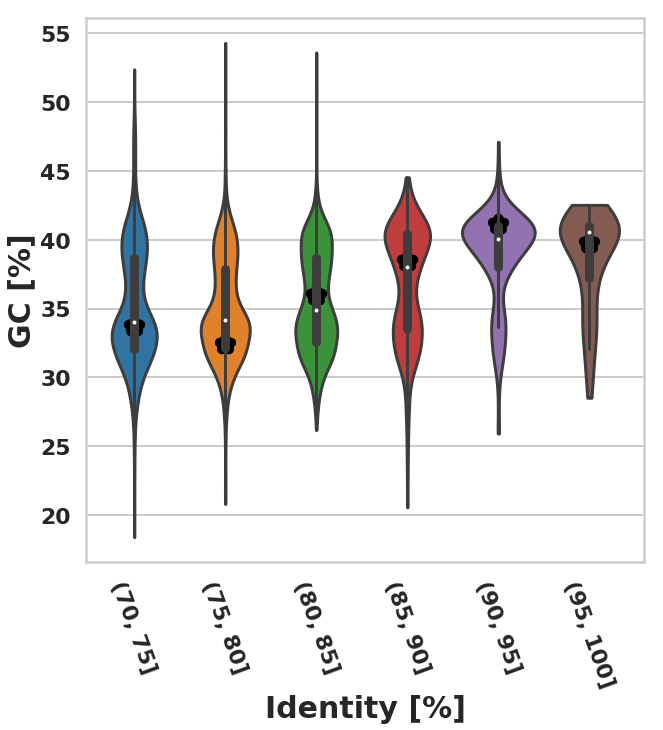

In [79]:
fig, ax = plt.subplots(figsize = (10,10))
sns.violinplot(x= 'GC_intervals', y='%GC', data = REPET_denovoTEs_df, ax = ax,cut=0)
x = [x.right for x in REPET_denovoTEs_df.groupby('GC_intervals').sum().index]
y = REPET_denovoTEs_df.groupby('GC_intervals')['GC_intervals_rel_GC'].sum()
x = ax.get_xticks()
ax.set_xticklabels(ax.get_xticklabels(), rotation = -70)
y = REPET_denovoTEs_df.groupby('GC_intervals')['GC_intervals_rel_GC'].sum()
ax.scatter(x,y, linewidths=10, color = 'black', marker = '*')
ax.set_xlabel('Identity [%]', **font)
ax.set_ylabel('GC [%]', **font)
out_fn = os.path.join(OUTPATH_Figures, 'TE_perID_vs_GC_consensus.violineplot.png')
fig.savefig(out_fn, dpi=600, bbox_inches = "tight")

### Summary
Yes there seems to be be a variation in GC content the older the TEs get the more AT rich they get. There seems to be two populations though. One with kind off stays the same and the other that changes.

Looks like most superfamilies follow this pattern except for Copias.

In [97]:
#look a bit what might be enriched or depleted in the uppre and lower population of TEs. Maybe Copias.
GC_low = 38

tmp_df = REPET_denovoTEs_df[(REPET_denovoTEs_df.GC_intervals == comparative_ints[1]) \
                   & (REPET_denovoTEs_df['%GC'] > GC_low)].groupby('COS')
tmp_df['TE'].count()/tmp_df['TE'].count().sum()

COS
False                      0.005333
ClassI:LARD:?              0.013333
ClassI:LTR:?               0.013333
ClassI:LTR:Copia           0.085333
ClassI:LTR:Gypsy           0.778667
ClassI:TRIM:?              0.040000
ClassII:MITE:?             0.005333
ClassII:Maverick:?         0.002667
ClassII:TIR:?              0.021333
ClassII:TIR:CACTA          0.024000
ClassII:TIR:Tc1-Mariner    0.005333
ClassII:TIR:hAT            0.002667
noCat                      0.002667
Name: TE, dtype: float64

ClassII:Helitron:?
ClassII:Maverick:?
ClassII:TIR:hAT
ClassII:TIR:PIF-Harbinger
ClassII:TIR:Tc1-Mariner
ClassII:TIR:CACTA
ClassII:TIR:?
ClassII:TIR:MuDR
False
ClassII:MITE:?
ClassII:?:?
noCat
ClassI:LINE:I
ClassI:LINE:?
ClassI:LTR:Gypsy
ClassI:LTR:?
ClassI:LTR:Copia
ClassI:LTR:Bel-Pao
ClassI:SINE:?
ClassI:LARD:?
ClassII:?:Novosib
ClassI:TRIM:?
ClassII:Crypton:Crypton
ClassII:Helitron:Helitron


/home/benjamin/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


ClassII:?:Ginger2_TDD
ClassI:?:?
ClassI:DIRS:?


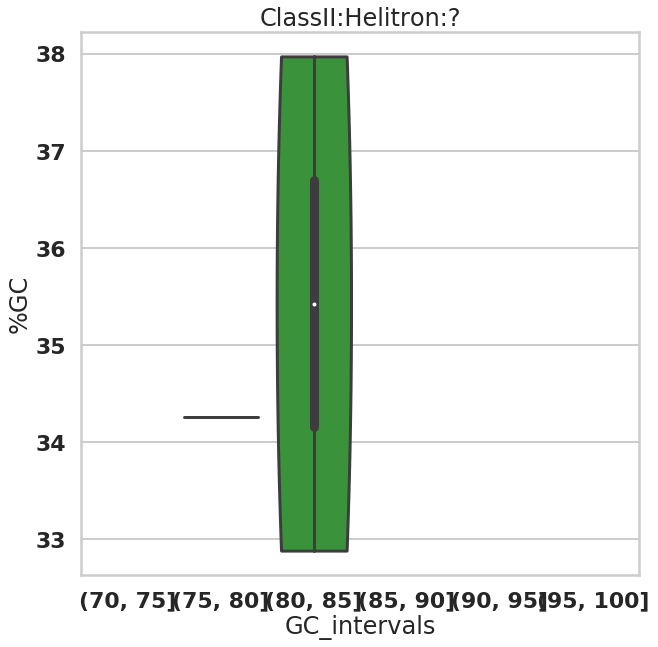

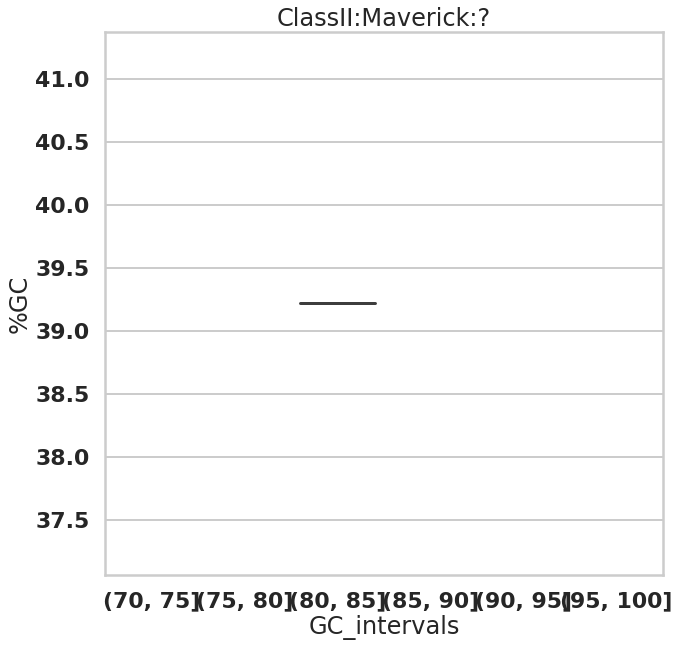

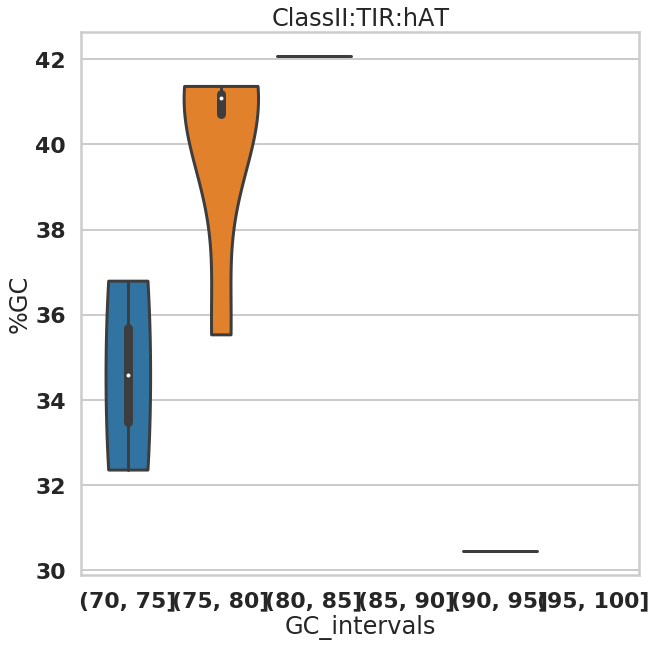

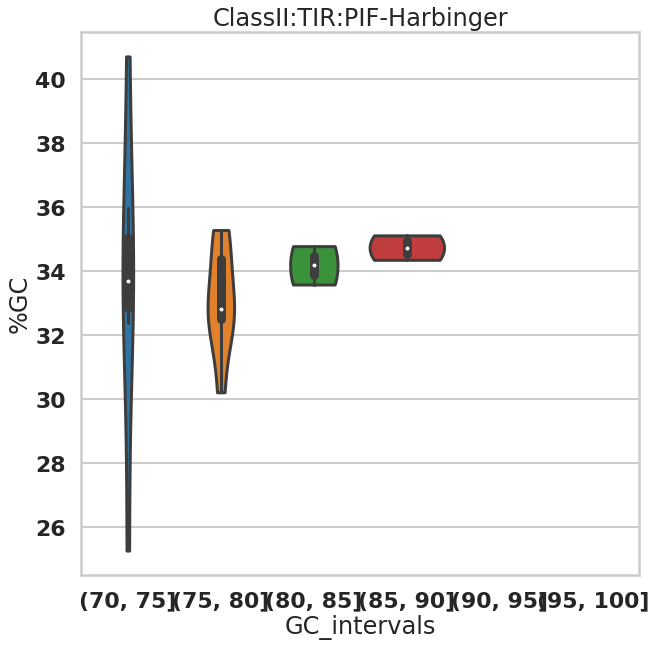

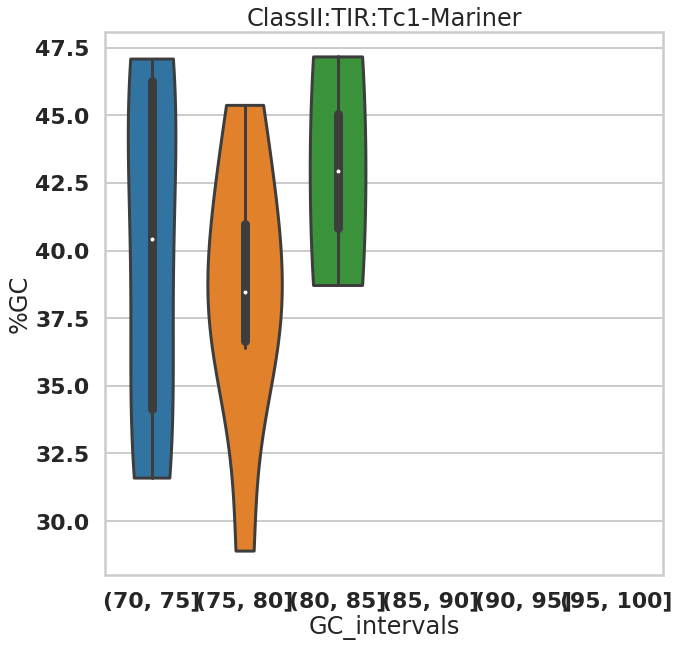

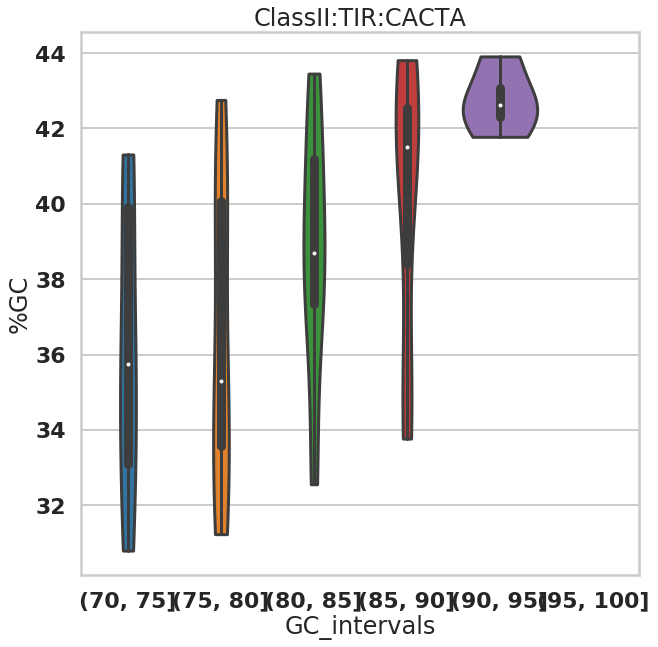

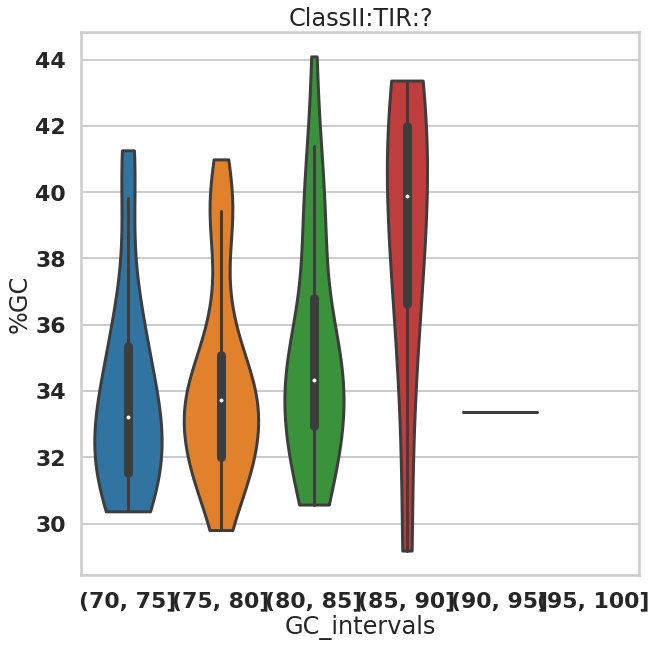

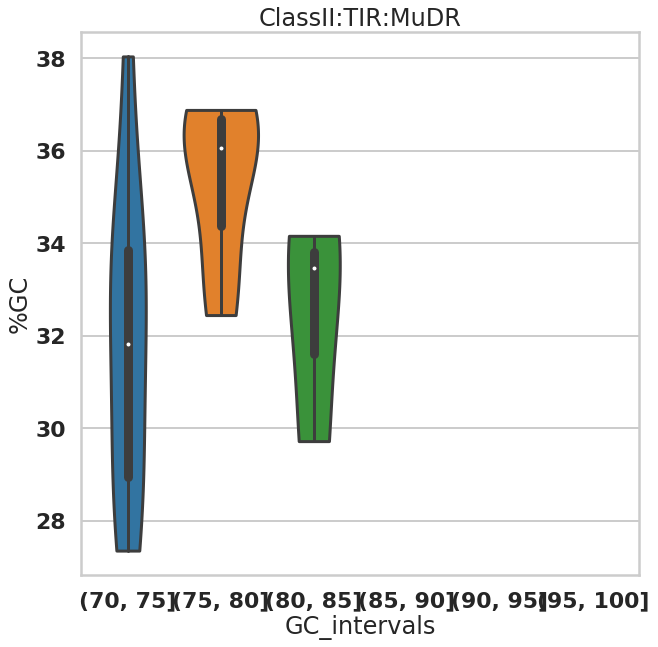

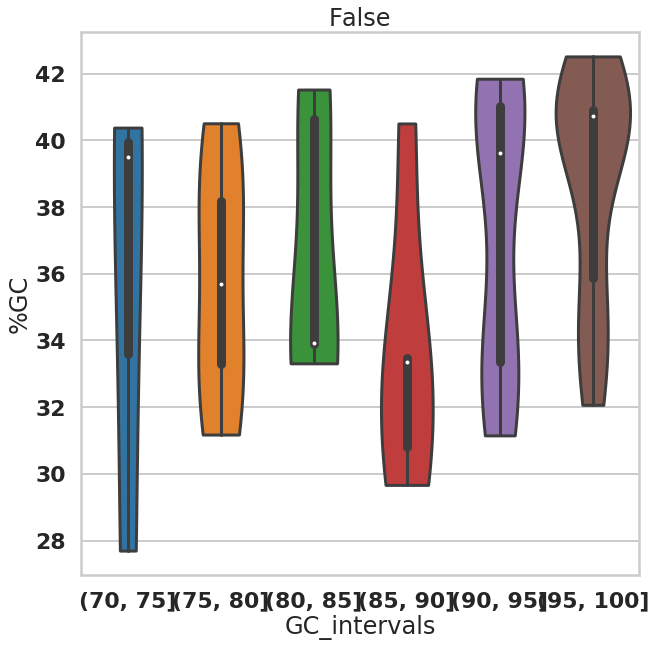

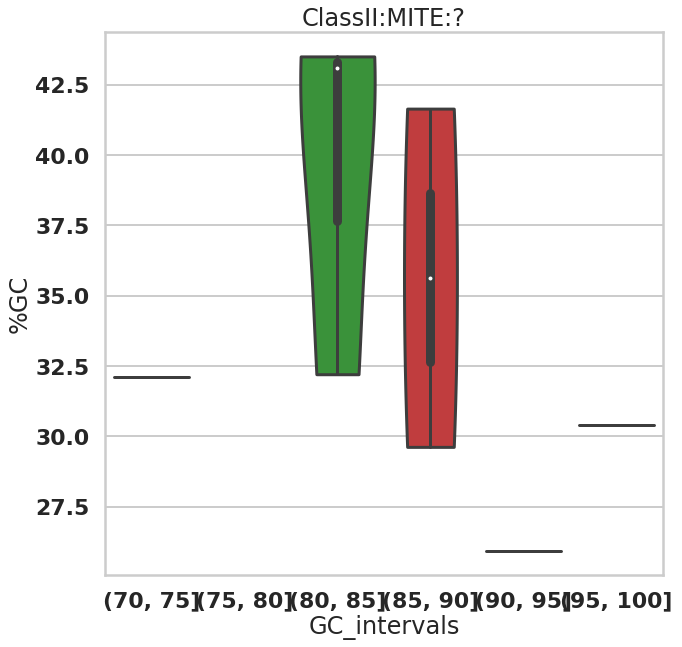

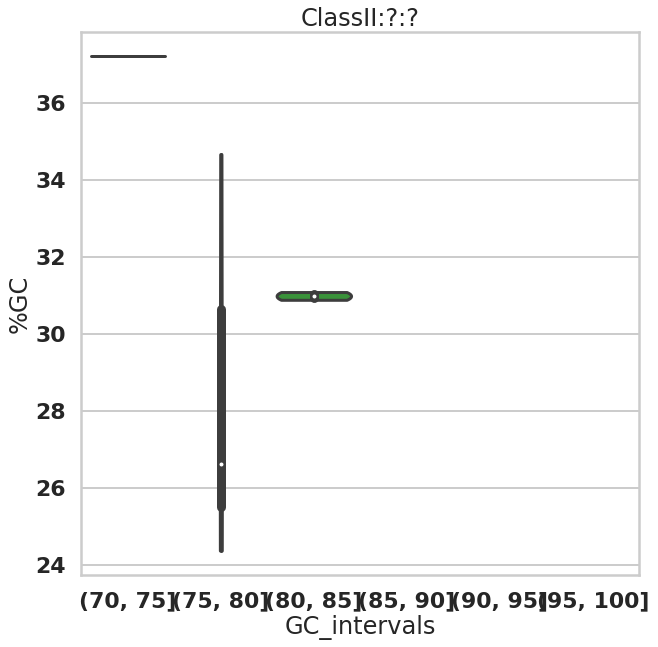

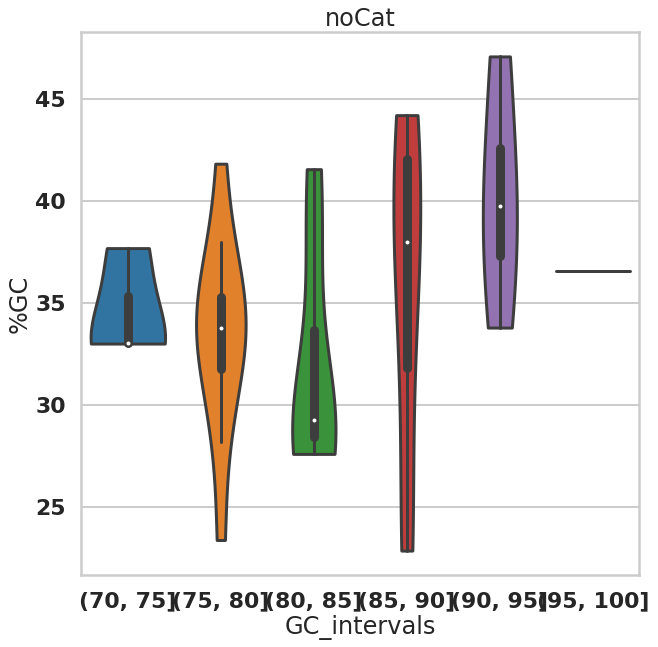

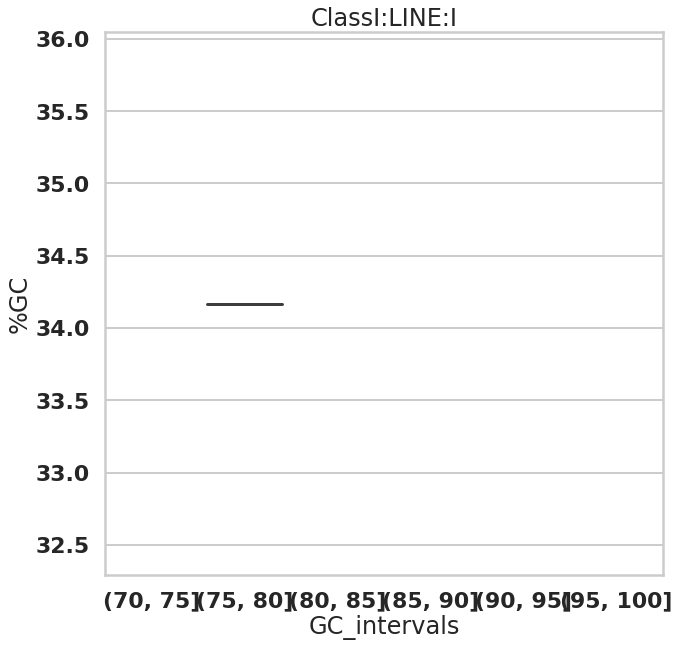

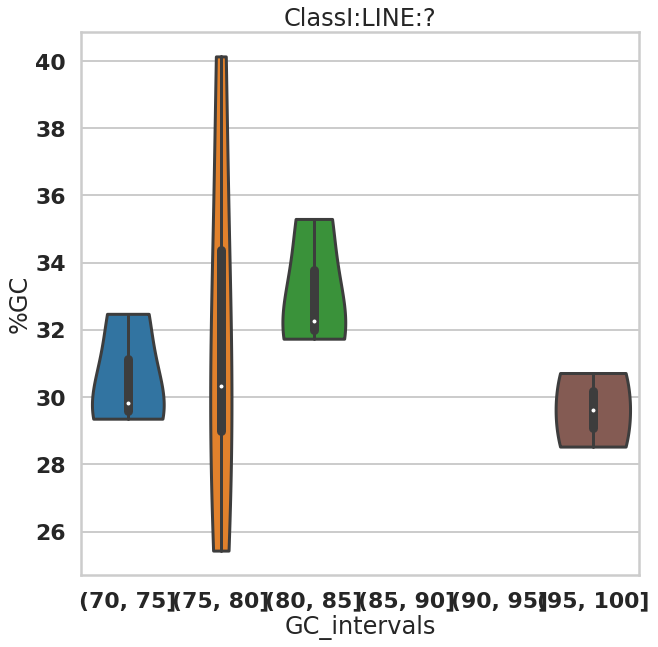

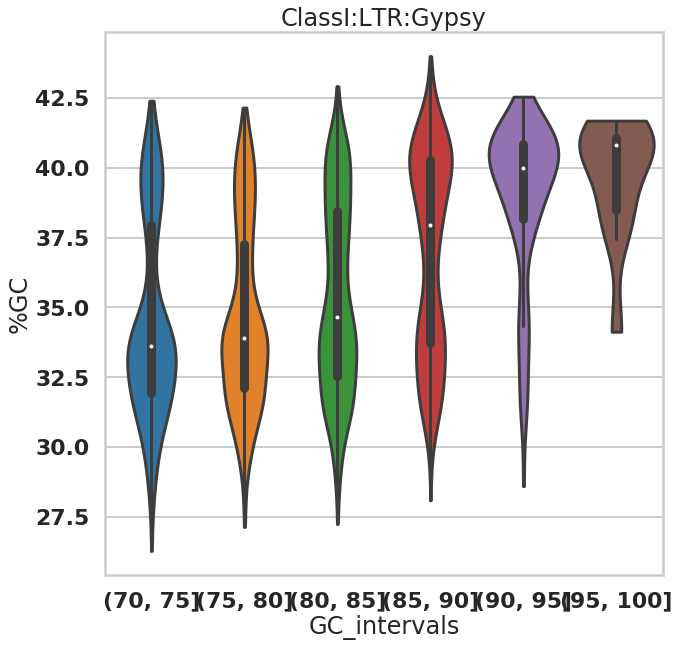

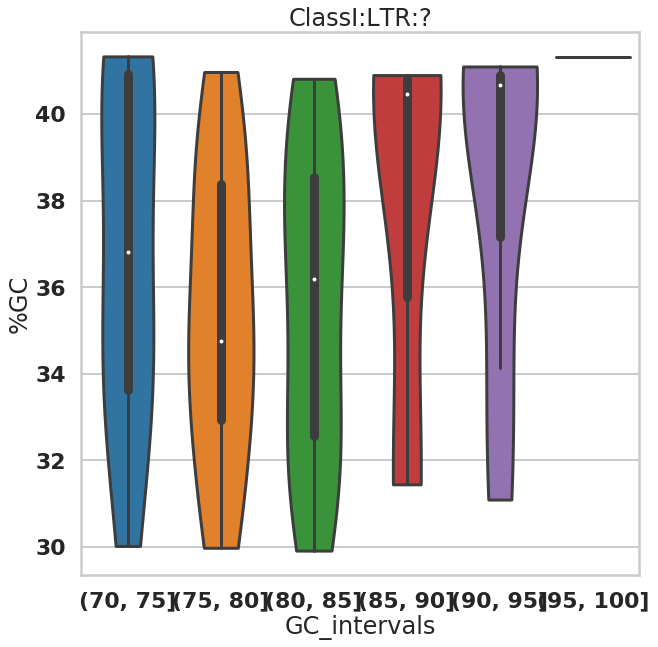

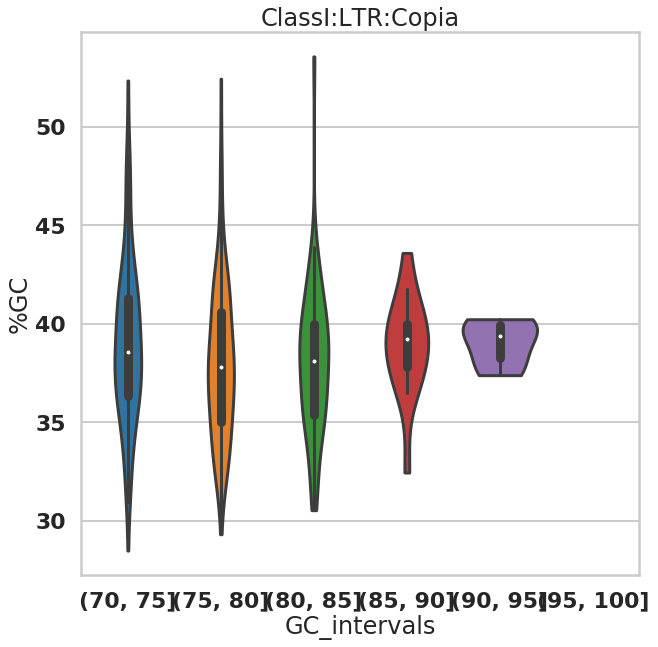

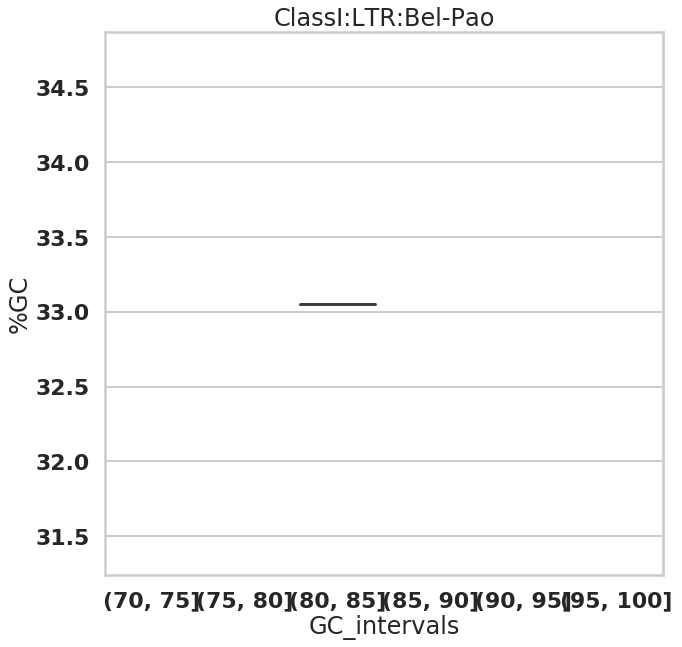

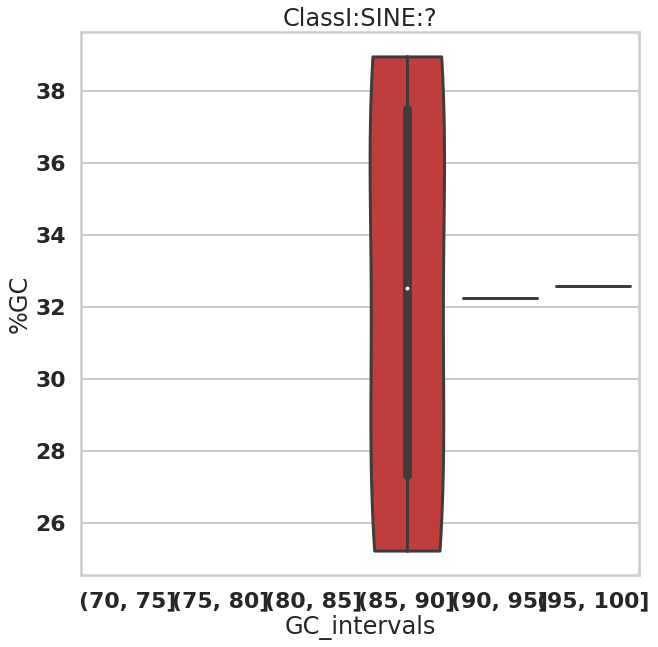

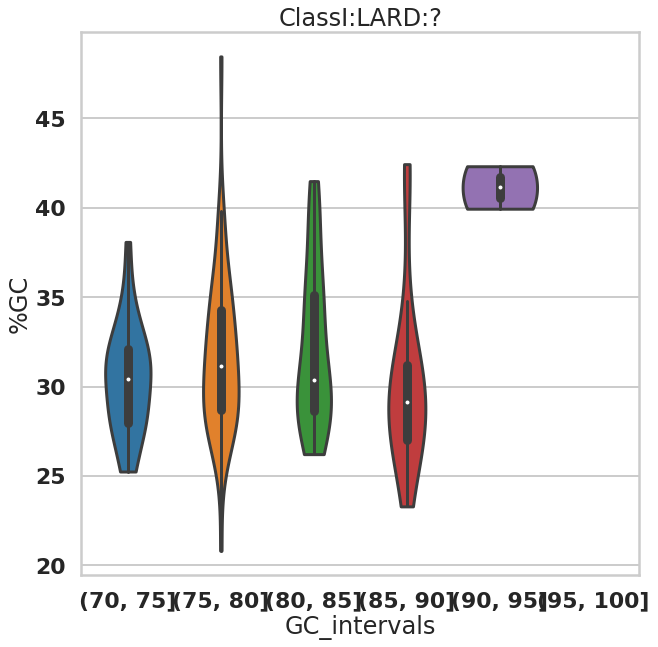

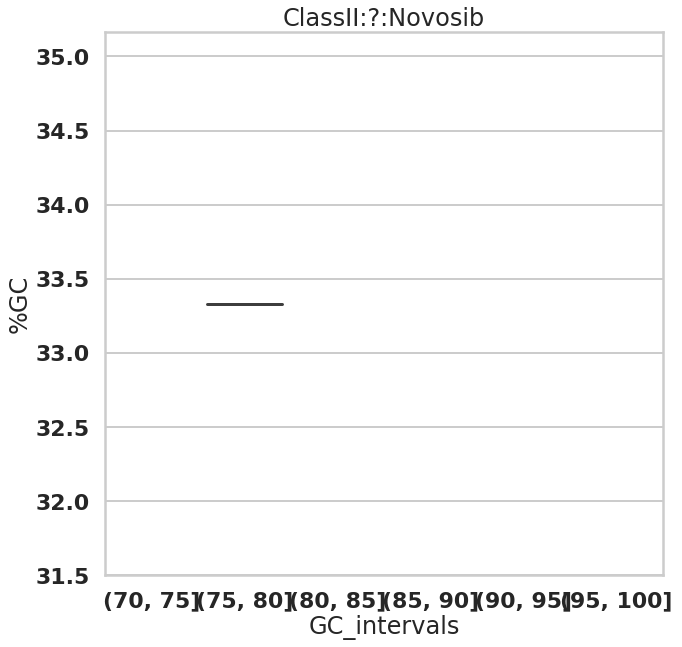

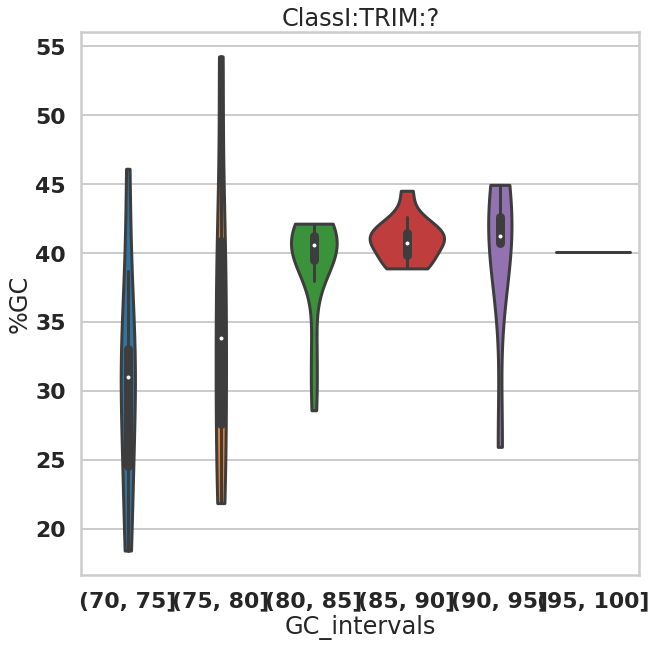

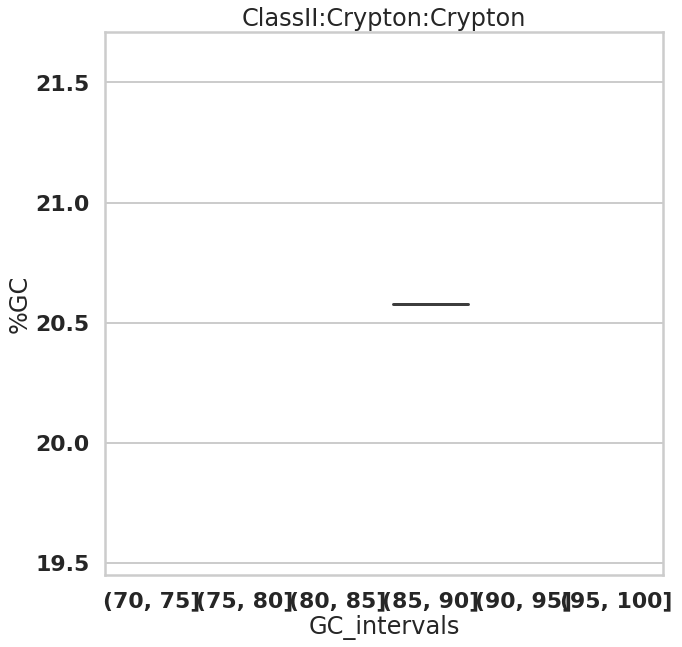

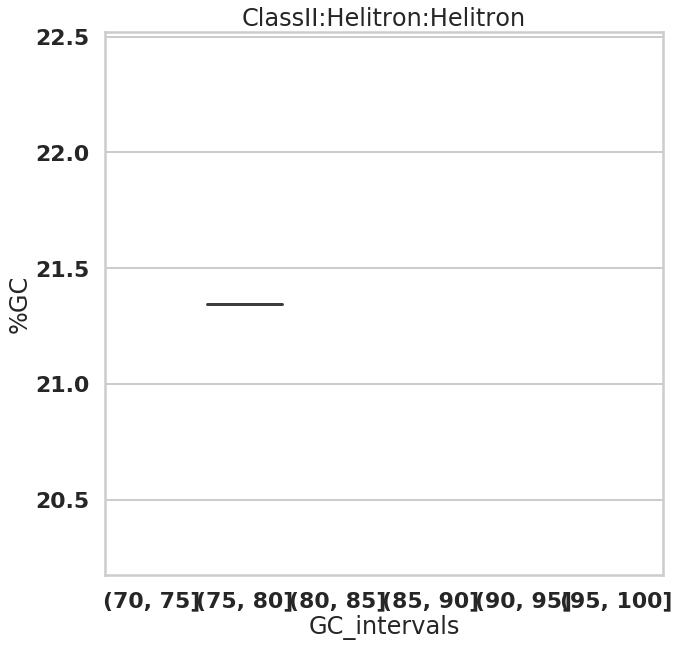

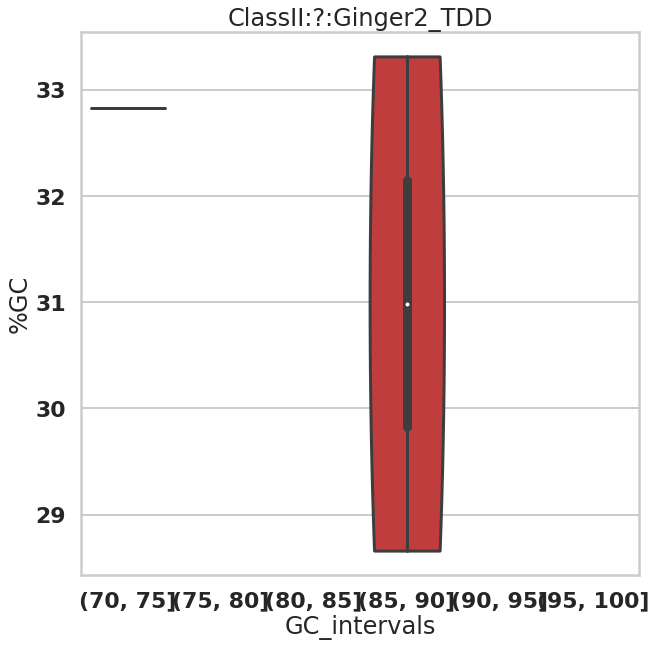

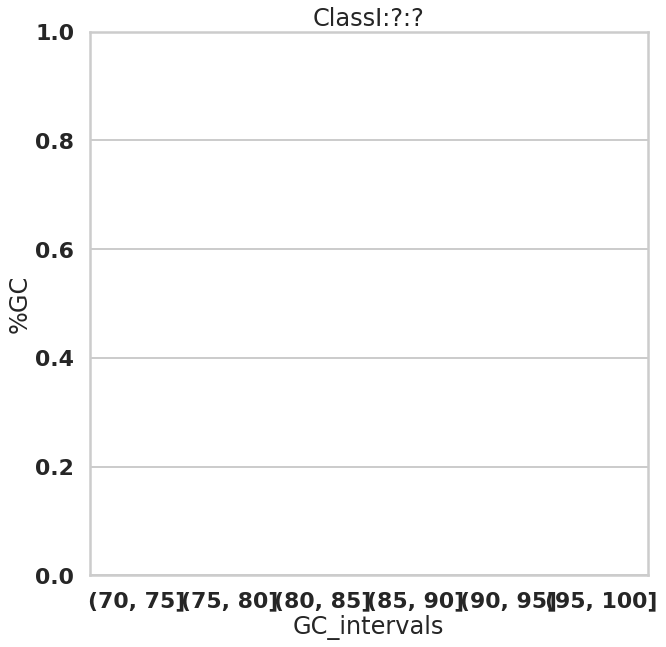

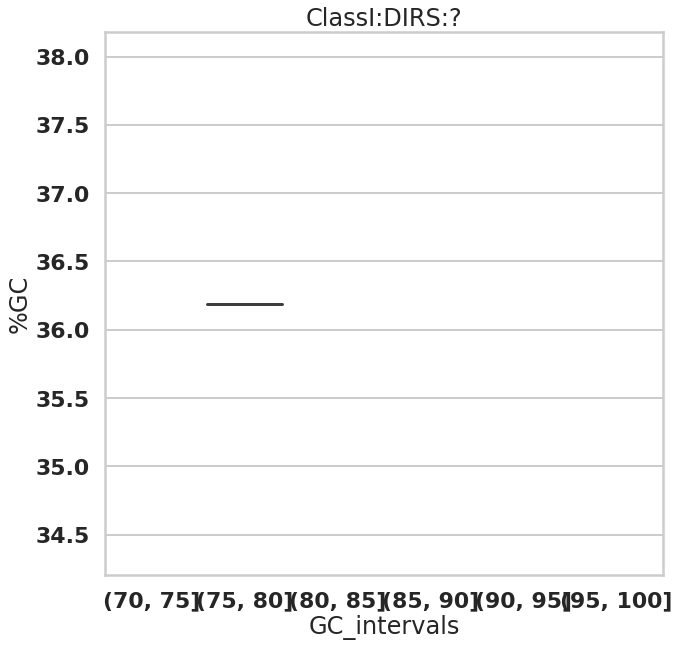

In [100]:
##look at MITEs or so quickly
for cos in REPET_denovoTEs_df.COS.unique():
    print(cos)
    fig, ax = plt.subplots(figsize = (10,10))
    sns.violinplot(x= 'GC_intervals', y='%GC', data = REPET_denovoTEs_df[REPET_denovoTEs_df.COS == cos], ax = ax,cut=0)
    ax.set_title(cos)

In [103]:
#safe out the new version of the REPET analysis file to be pulled in with the dinuc_counting
REPET_denovoTEs_df.to_csv(\
            os.path.join(OUTPATH, '%s_chr_allTEs_nr_noSSR_join_path.annotStatsPerTE.v2.tab' % 'MR_P2_a0'),\
                                     index = None, sep='\t')

## Follow on from the idea of RIP and AT rich regions. First do some analysis on AT-content.



In [105]:
AT_analysis = '../../AT_analysis'
if not os.path.exists(AT_analysis):
    os.makedirs(AT_analysis)

In [106]:
gene_bed_fn = '../../effector_analysis/APSI_primary_v1.transcript.genes.bed'
repeat_bed_fn = '../../TE_analysis/APSI_primary_v1.MR_P2A_300Mb.REPET_fix.superfamily.bed'
oc_bed_fn = os.path.join(AT_analysis, 'regions.bed')

In [ ]:
#run Occultercut on the command line in the new folder for AT analysis /home/benjamin/anaconda3/OcculterCut_v1.1/
#/home/benjamin/anaconda3/OcculterCut_v1.1/OcculterCut -f ../genome/APSI_primary_v1.fa

In [107]:
#get genome files and bed window files
window_fn_dict = {}
window_bed_dict = {}
window_fn_dict['w50kb_s10kb'] = os.path.join(AT_analysis, '%s.w50.s10.bed' % genome)
window_fn_dict['w5kb_s1kb'] = os.path.join(AT_analysis, '%s.w5.s1.bed' % genome)
window_fn_dict['w1kb_s200'] = os.path.join(AT_analysis, '%s.w1.s200.bed' % genome)
window_fn_dict['w1kb'] = os.path.join(AT_analysis, '%s.w1.bed' % genome)
window_fn_dict['w100b'] = os.path.join(AT_analysis, '%s.w100b.bed' % genome)
genome_size_f_fn = os.path.join(genome_folder, '%s.genome_file' % genome)
contig_fn = os.path.join(genome_folder,'%s.fa' % genome )


In [108]:
!bedtools makewindows -g {genome_size_f_fn} -w 5000 -s 1000 > {window_fn_dict['w5kb_s1kb']}
!bedtools makewindows -g {genome_size_f_fn} -w 1000 -s 200 > {window_fn_dict['w1kb_s200']}

In [109]:
!bedtools makewindows -g {os.path.abspath(genome_size_f_fn)} -w 100 > {window_fn_dict['w100b']}

In [110]:
os.path.abspath(genome_size_f_fn)

'/home/benjamin/myrtle_rust/genome_v03/genome/APSI_primary_v1.genome_file'

In [111]:
#new make a bedtools window dataframe
for key, value in window_fn_dict.items() :
    window_bed_dict[key] = BedTool(value)

In [112]:
#now make an AT bed df dict and save it out
window_AT_dict = {}
for key, value in window_bed_dict.items():
    tmp_df = value.nucleotide_content(fi=contig_fn).to_dataframe().iloc[1:,[0,1,2, 3]]
    tmp_df.rename(columns={'name':'%AT'}, inplace=True)
    tmp_fn = window_fn_dict[key].replace('bed', 'AT.bed')
    tmp_df.to_csv(tmp_fn, header=None, sep='\t', index=None)
    tmp_fn = window_fn_dict[key].replace('bed', 'AT.circabed')
    tmp_df.to_csv(tmp_fn, sep='\t', index=None)
    window_AT_dict[key] = tmp_df
    tmp_df = ''

/home/benjamin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/home/benjamin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/home/benjamin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/home/benjamin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/home/be

In [113]:
#now check the AT content in genes and such
intervals = pd.interval_range(start=0.2, end=1.0, closed='right', periods=80)
gene_at_df, gene_at_sum_df = AT_content_df(gene_bed_fn, contig_fn, intervals)
gene_at_sum_df['norm_W_Len'].max()

0.10501506931078348

In [114]:
repeat_at_df, repeat_at_sum_df = AT_content_df(repeat_bed_fn, contig_fn, intervals)

In [115]:
oc_df, oc_sum_df = AT_content_df(oc_bed_fn, contig_fn, intervals)

In [116]:
w_1kb_df , w_1kb_sum_df = AT_content_df(os.path.abspath(window_fn_dict['w1kb']), contig_fn, intervals)

In [117]:
w_100b_df , w_100b_sum_df = AT_content_df(os.path.abspath(window_fn_dict['w100b']), contig_fn, intervals)

In [118]:
w_at_df, w_at_sum_df = AT_content_df(os.path.abspath(window_fn_dict['w1kb_s200']), contig_fn, intervals)

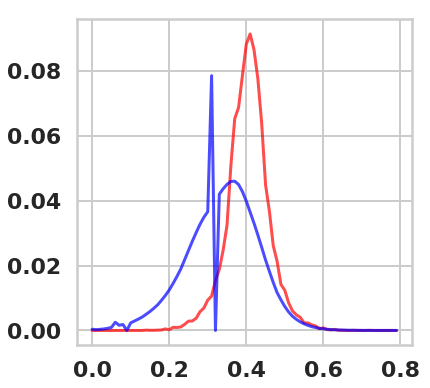

In [120]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(1-gene_at_sum_df['Interval_edge'], gene_at_sum_df['norm_count_AT'], '-', color='r', label = 'genes',  linewidth=3, alpha = 0.7)
ax.plot(1-w_100b_sum_df['Interval_edge'], w_100b_sum_df['norm_count_AT'], '-', color='b', label = 'windows',  linewidth=3, alpha = 0.7)
#ax.plot(1-repeat_at_sum_df['Interval_edge'], repeat_at_sum_df['norm_count_AT'], '-', color='g', label = 'repeats',  linewidth=3, alpha = 0.7)
#ax.plot(1-oc_sum_df['Interval_edge'], oc_sum_df['norm_count_AT'], '-', color='black', label = 'occulter',  linewidth=3, alpha = 0.7)
#outfn = os.path.join(OUTPATH_Figures, 'APSI_primary_v1.TE_family_variation_analysis.png')
#plt.savefig(outfn, dpi=600,bbox_inches='tight')




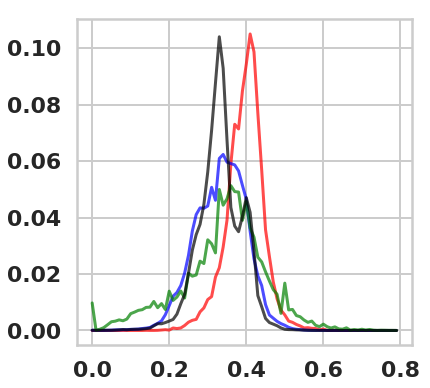

In [121]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(1-gene_at_sum_df['Interval_edge'], gene_at_sum_df['norm_W_Len'], '-', color='r', label = 'genes',  linewidth=3, alpha = 0.7)
ax.plot(1-w_100b_sum_df['Interval_edge'], w_1kb_sum_df['norm_W_Len'], '-', color='b', label = 'windows',  linewidth=3, alpha = 0.7)
ax.plot(1-repeat_at_sum_df['Interval_edge'], repeat_at_sum_df['norm_count_AT'], '-', color='g', label = 'repeats',  linewidth=3, alpha = 0.7)
ax.plot(1-oc_sum_df['Interval_edge'], oc_sum_df['norm_W_Len'], '-', color='black', label = 'Occultercut',  linewidth=3, alpha = 0.7)

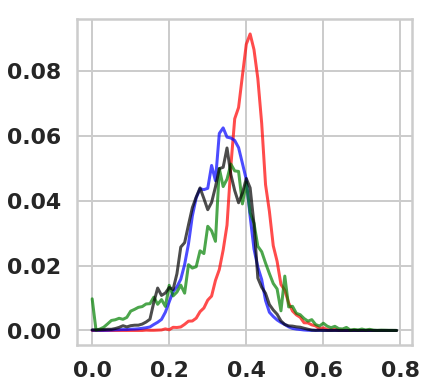

In [122]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(1-gene_at_sum_df['Interval_edge'], gene_at_sum_df['norm_count_AT'], '-', color='r', label = 'genes',  linewidth=3, alpha = 0.7)
ax.plot(1-w_at_sum_df['Interval_edge'], w_at_sum_df['norm_count_AT'], '-', color='b', label = 'windows',  linewidth=3, alpha = 0.7)
ax.plot(1-repeat_at_sum_df['Interval_edge'], repeat_at_sum_df['norm_count_AT'], '-', color='g', label = 'repeats',  linewidth=3, alpha = 0.7)
ax.plot(1-oc_sum_df['Interval_edge'], oc_sum_df['norm_count_AT'], '-', color='black', label = 'occulter',  linewidth=3, alpha = 0.7)

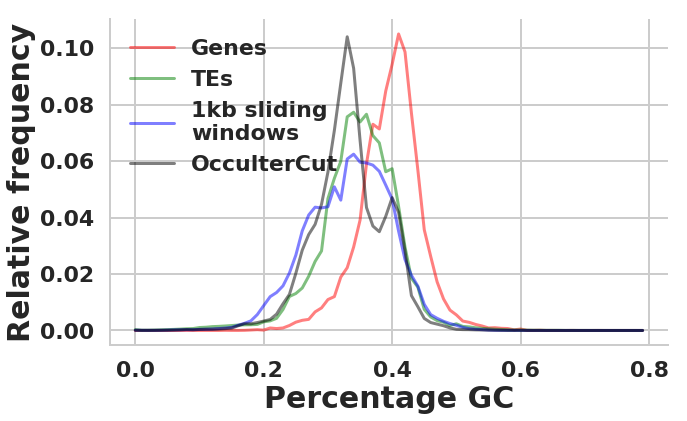

In [123]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(1-gene_at_sum_df['Interval_edge'], gene_at_sum_df['norm_W_Len'], '-', color='r', label = 'Genes',  linewidth=3, alpha = 0.5)
ax.plot(1-repeat_at_sum_df['Interval_edge'], repeat_at_sum_df['norm_W_Len'], '-', color='g', label = 'TEs',  linewidth=3, alpha = 0.5)
ax.plot(1-w_at_sum_df['Interval_edge'], w_at_sum_df['norm_W_Len'], '-', color='b', label = '1kb sliding \nwindows',  linewidth=3, alpha = 0.5)
ax.plot(1-oc_sum_df['Interval_edge'], oc_sum_df['norm_W_Len'], '-', color='black', label = 'OcculterCut',  linewidth=3, alpha = 0.5)

ax.legend()
ax.set_ylabel('Relative frequency', **font)
ax.set_xlabel('Percentage GC', **font)
plt.legend(loc='upper left', frameon=False)
#['top','bottom','left','right']
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
ax.tick_params(width=2)

outfn = os.path.join(OUTPATH_Figures, 'APSI_primary_v1.GC_variation_analysis.png')

plt.savefig(outfn, dpi=600,bbox_inches='tight')

In [124]:
pst104_genome_fa_fn = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/092017_assembly/Pst_104E_v13_p_ctg.fa'
pst104_genebed_fn = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/092017_assembly/Pst_104E_v13_p_ctg.gene.bed'
pst104_repetbed_fn = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/REPET/TE_analysis/Pst_104E_v13_p_ctg.104Ep_DK0911p.REPET.superfamily.sorted.bed'
pst104_window_fn = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/window_analysis/Pst_104E_v12_p_ctg.w1.s200.bed'

In [125]:
pst104_gene_df, pst104_gene_sum_df = AT_content_df(pst104_genebed_fn, pst104_genome_fa_fn, intervals)
pst104_repetbed_df, pst104_repetbed_sum_df = AT_content_df(pst104_repetbed_fn, pst104_genome_fa_fn, intervals)
pst104_window_df, pst104_window_sum_df = AT_content_df(pst104_window_fn, pst104_genome_fa_fn, intervals)

In [126]:
print(1-pst104_repetbed_df['%AT'].mean())
print(1-pst104_gene_df['%AT'].mean())

0.439776837990843
0.4584822291562034


In [127]:
print(1- gene_at_df['%AT'].mean())
print(1- repeat_at_df['%AT'].mean())

0.4100335985065753
0.3441379603560951


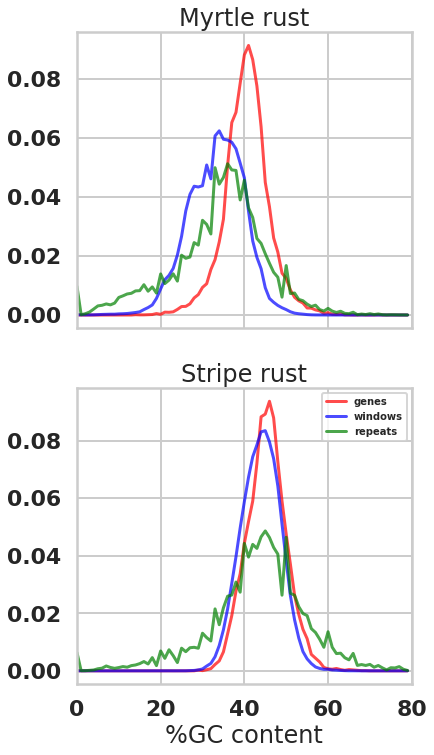

In [128]:
fig, ax = plt.subplots(2, 1, figsize=(6,12), sharex=True)

x_values = (1-gene_at_sum_df['Interval_edge'])*100
ax[0].plot(x_values, gene_at_sum_df['norm_count_AT'], '-', color='r', label = 'genes',  linewidth=3, alpha = 0.7)
ax[0].plot(x_values, w_at_sum_df['norm_count_AT'], '-', color='b', label = 'windows',  linewidth=3, alpha = 0.7)
ax[0].plot(x_values, repeat_at_sum_df['norm_count_AT'], '-', color='g', label = 'repeats',  linewidth=3, alpha = 0.7)
ax[1].plot(x_values,pst104_gene_sum_df['norm_count_AT'], '-', color='r', label = 'genes',  linewidth=3, alpha = 0.7)
ax[1].plot(x_values, pst104_window_sum_df['norm_count_AT'], '-', color='b', label = 'windows',  linewidth=3, alpha = 0.7)
ax[1].plot(x_values, pst104_repetbed_sum_df['norm_count_AT'], '-', color='g', label = 'repeats',  linewidth=3, alpha = 0.7)


ax[1].set_xlim(0,80)
ax[0].set_title('Myrtle rust')

ax[1].set_title('Stripe rust')
ax[1].set_xlabel('%GC content')
plt.legend(loc='best', fontsize = 10)

In [129]:
pst104_genome_fa_fn = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/092017_assembly/Pst_104E_v13_p_ctg.fa'
pst104_genebed_fn = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/092017_assembly/Pst_104E_v13_p_ctg.gene.bed'
pst104_oc_fn = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/TE_analysis/compositionGC.txt'
pst104_repetbed_fn = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/REPET/TE_analysis/Pst_104E_v13_p_ctg.104Ep_DK0911p.REPET.superfamily.sorted.bed'

In [130]:
pst104_window_dir = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/window_analysis/20191212'

In [131]:
1 - gene_at_df['%AT'].mean()

0.4100335985065753

In [132]:
1 - w_at_df['%AT'].mean()

0.33815799984741546

### Look at Occultor cut

In [133]:
m_oc_df = pd.read_csv(os.path.join(AT_analysis, 'compositionGC.txt'), sep=' ', header=None)
s_oc_df = pd.read_csv(pst104_oc_fn, sep=' ', header=None)

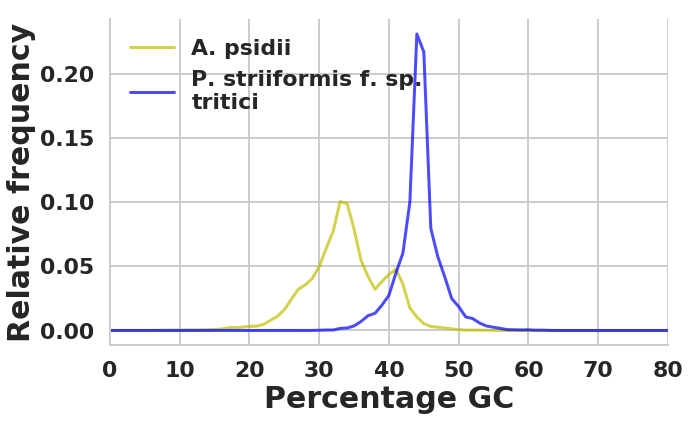

In [134]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(m_oc_df[0], m_oc_df[1], '-', color='y', label = 'A. psidii ',  linewidth=3, alpha = 0.7)
ax.plot(s_oc_df[0], s_oc_df[1], '-', color='b', label = 'P. striiformis f. sp. \ntritici',  linewidth=3, alpha = 0.7)
ax.set_ylabel('Relative frequency', **font)
ax.set_xlabel('Percentage GC', **font)
ax.set_xlim(0,80)
plt.legend(loc='upper left', frameon=False)
#['top','bottom','left','right']
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
ax.tick_params(width=2)
outfn = os.path.join(OUTPATH_Figures, 'APSI_primary_v1.occulturcut.png')

plt.savefig(outfn, dpi=600,bbox_inches='tight')

In [135]:
#convert occulter cut regions file to bed
oc_gff_fn = os.path.join(AT_analysis, 'regions.gff3')
oc_gff_df = pd.read_csv(oc_gff_fn, sep='\t', header=None)
oc_gff_df['bed_start'] = oc_gff_df[3] - 1

In [136]:
oc_gff_df.loc[:, [0, 'bed_start', 4]].to_csv(oc_gff_fn.replace('.gff3', '.bed'), sep='\t', index=None, header=None)

In [137]:
oc_gff_df.head()

,0,1,2,3,4,5,6,7,8,bed_start
0,APSI_P001,occult,region,1,1413,.,+,.,ID=0.0,0
1,APSI_P001,occult,region,1414,2428,.,+,.,ID=0.1,1413
2,APSI_P001,occult,region,2429,4311,.,+,.,ID=0.2,2428
3,APSI_P001,occult,region,4312,7159,.,+,.,ID=0.3,4311
4,APSI_P001,occult,region,7160,9086,.,+,.,ID=0.4,7159


In [138]:
oc_df.head()

,0,1,2,%AT,W_Len,Intervals
0,APSI_P001,0,1413,0.801132,1413,"(0.8, 0.81]"
1,APSI_P001,1413,2428,0.745813,1015,"(0.74, 0.75]"
2,APSI_P001,2428,4311,0.664896,1883,"(0.66, 0.67]"
3,APSI_P001,4311,7159,0.745435,2848,"(0.74, 0.75]"
4,APSI_P001,7159,9086,0.773223,1927,"(0.77, 0.78]"


#### Look at the interval length of the different AT rich bins
meaning how long are the AT rich stretches.

In [140]:
oc_df['W_Len'] = oc_df[2] - oc_df[1]
oc_df['Interval_edge'] = oc_df['Intervals'].apply(lambda x: x.left)
oc_df['GC_Interval_edge'] = 1 - oc_df['Interval_edge'].astype('float')
oc_df['log_W_Len'] = np.log10(oc_df['W_Len'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]),
 <a list of 62 Text xticklabel objects>)

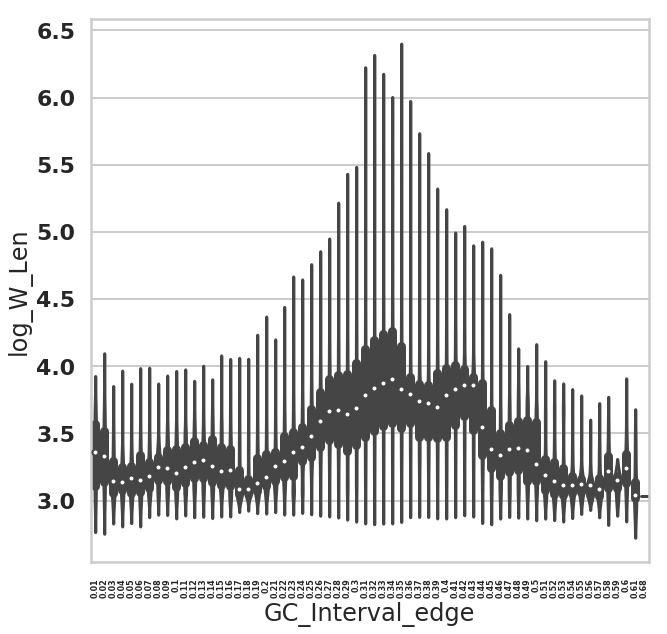

In [141]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.violinplot(x='GC_Interval_edge', y='log_W_Len', data=oc_df)
plt.xticks(rotation=90, fontsize=8)

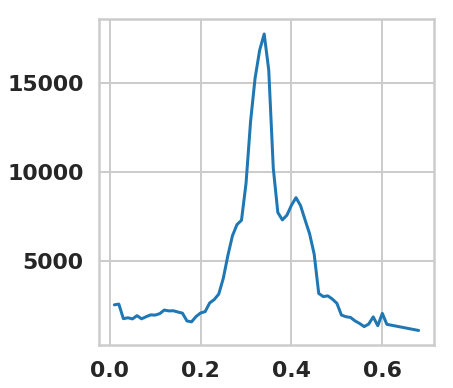

In [142]:
fig, ax = plt.subplots(figsize=(6,6))
x = list(oc_df.groupby('GC_Interval_edge')['W_Len'].mean().index)
ax.plot(x, oc_df.groupby('GC_Interval_edge')['W_Len'].mean())

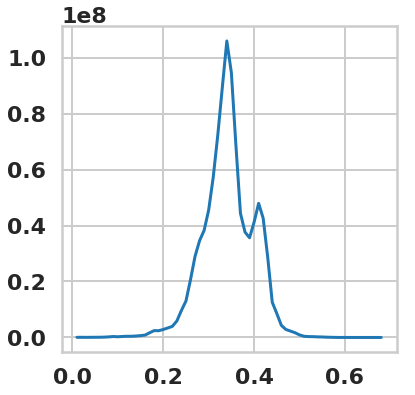

In [143]:
fig, ax = plt.subplots(figsize=(6,6))
x = list(oc_df.groupby('GC_Interval_edge')['W_Len'].mean().index)
ax.plot(x, oc_df.groupby('GC_Interval_edge')['W_Len'].sum())